In [ ]:
!pip install optuna

### Defining seven basis function for RBF network comparision:

In [4]:
import numpy as np
# Define seven basis functions
def gaussian(x, c, s):
    return np.exp(-np.linalg.norm(x - c, axis=1)**2 / (2 * s**2))

def multiquadratic(x, c, s):
    return np.sqrt(np.linalg.norm(x - c, axis=1)**2 + s**2)

def inverse_multiquadratic(x, c, s):
    return 1 / np.sqrt(np.linalg.norm(x - c, axis=1)**2 + s**2)

def thin_plate_spline(x, c, s):
    r = np.linalg.norm(x - c, axis=1)
    return (r**2) * np.log(r + 1e-6)  # Added small constant to avoid log(0)

def logistic(x, c, s):
    return 1 / (1 + np.exp(-np.linalg.norm(x - c, axis=1) / s))

def cubic(x, c, s):
    return np.linalg.norm(x - c, axis=1)**3

def linear(x, c, s):
    return np.linalg.norm(x - c, axis=1)

## Comparision between traditional backprop and moore-penrose inverse (gaussian as the basis function)

### training with backprop:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Set random seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SP500_normalized.csv")

# Define features and target
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators].values
y = df["Direction"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RBFN with K-means-based initialization and backpropagation
class RBFN_Backprop:
    def __init__(self, input_dim, num_neurons, X_train, lr=0.01):
        self.num_neurons = num_neurons
        self.lr = lr

        # Initialize centers using K-means
        kmeans = KMeans(n_clusters=num_neurons, random_state=42).fit(X_train)
        self.centers = kmeans.cluster_centers_

        # Initialize sigma as distance to nearest center
        self.sigma = np.zeros(num_neurons)
        for i in range(num_neurons):
            dists = np.linalg.norm(self.centers[i] - np.delete(self.centers, i, axis=0), axis=1)
            self.sigma[i] = np.min(dists)
        self.sigma[self.sigma == 0] = 1e-4  # Avoid zero division

        # Initialize weights
        self.weights = np.random.randn(num_neurons)

    def gaussian(self, x, c, sigma):
        return np.exp(-np.linalg.norm(x - c, axis=1)**2 / (2 * sigma**2))

    def _rbf_layer(self, X):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i in range(self.num_neurons):
            G[:, i] = self.gaussian(X, self.centers[i], self.sigma[i])
        return G

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward(self, X):
        self.G = self._rbf_layer(X)
        self.output = self.sigmoid(np.dot(self.G, self.weights))
        return self.output

    def backward(self, X, y_true):
        m = X.shape[0]
        error = self.output - y_true
        grad_w = np.dot(self.G.T, error) / m

        grad_c = np.zeros_like(self.centers)
        grad_s = np.zeros_like(self.sigma)

        for i in range(self.num_neurons):
            diff = X - self.centers[i]
            g_i = self.G[:, i]
            common_term = error * self.weights[i] * g_i
            grad_c[i] = np.sum((common_term[:, None] * diff) / (self.sigma[i] ** 2), axis=0) / m
            grad_s[i] = np.sum(common_term * np.linalg.norm(diff, axis=1) ** 2 / (self.sigma[i] ** 3)) / m

        # Update
        self.weights -= self.lr * grad_w
        self.centers -= self.lr * grad_c
        self.sigma -= self.lr * grad_s

    def train(self, X, y, epochs=50):
        for _ in range(epochs):
            self.forward(X)
            self.backward(X, y)

    def predict(self, X):
        probs = self.forward(X)
        return (probs > 0.5).astype(int)

# Use only Gaussian basis
# basis_functions = ["multiquadratic"]
basis_functions = ["gaussian", "multiquadratic", "inverse_multiquadratic",
                   "thin_plate_spline", "logistic", "cubic", "linear"]
hidden_neurons_list = range(10, 200, 5)
num_runs = 20  

results = {basis: [] for basis in basis_functions}

for num_neurons in hidden_neurons_list:
    for basis in basis_functions:
        acc_scores = []
        f1_scores = []
        for _ in range(num_runs):
            model = RBFN_Backprop(input_dim=X.shape[1], num_neurons=num_neurons, X_train=X_train, lr=0.05)
            model.train(X_train, y_train, epochs=25)

            y_pred = model.predict(X_test)
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        results[basis].append((num_neurons, np.mean(acc_scores), np.mean(f1_scores)))

# Plotting
hidden_sizes = {basis: [res[0] for res in results[basis]] for basis in basis_functions}
accuracy_dict = {basis: [res[1] for res in results[basis]] for basis in basis_functions}
f1_dict = {basis: [res[2] for res in results[basis]] for basis in basis_functions}



# Accuracy plot
fig_accuracy = go.Figure()
for basis in basis_functions:
    fig_accuracy.add_trace(go.Scatter(x=hidden_sizes[basis], y=accuracy_dict[basis],
                                      mode="lines+markers", name=f"{basis} Accuracy"))
fig_accuracy.update_layout(title="Accuracy vs Hidden Neurons (Backprop RBFN)",
                           xaxis_title="Hidden Neurons", yaxis_title="Accuracy",
                           template="plotly_white", hovermode="x unified")
fig_accuracy.show()

# F1 Score plot
fig_f1 = go.Figure()
for basis in basis_functions:
    fig_f1.add_trace(go.Scatter(x=hidden_sizes[basis], y=f1_dict[basis],
                                mode="lines+markers", name=f"{basis} F1-Score"))
fig_f1.update_layout(title="F1-Score vs Hidden Neurons (Backprop RBFN)",
                     xaxis_title="Hidden Neurons", yaxis_title="F1-Score",
                     template="plotly_white", hovermode="x unified")
fig_f1.show()


## moore penrose

### RBFN 

In [5]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# RBF Network class
class RBFN:
    def __init__(self, num_neurons=10, basis_function='gaussian', reg_param=0.01):
        self.num_neurons = num_neurons
        self.basis_function = basis_function
        self.reg_param = reg_param
        self.centers = None
        self.sigma = None
        self.weights = None

    def _apply_basis_function(self, x):
        phi_matrix = np.zeros((x.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            if self.basis_function == 'gaussian':
                phi_matrix[:, i] = gaussian(x, center, self.sigma)
            elif self.basis_function == 'multiquadratic':
                phi_matrix[:, i] = multiquadratic(x, center, self.sigma)
            elif self.basis_function == 'inverse_multiquadratic':
                phi_matrix[:, i] = inverse_multiquadratic(x, center, self.sigma)
            elif self.basis_function == 'thin_plate_spline':
                phi_matrix[:, i] = thin_plate_spline(x, center, self.sigma)
            elif self.basis_function == 'logistic':
                phi_matrix[:, i] = logistic(x, center, self.sigma)
            elif self.basis_function == 'cubic':
                phi_matrix[:, i] = cubic(x, center, self.sigma)
            elif self.basis_function == 'linear':
                phi_matrix[:, i] = linear(x, center, self.sigma)
        return phi_matrix

    def fit(self, X, y):
        # Step 1: Compute centers using K-means clustering
        if isinstance(X, pd.DataFrame):
            X = X.values
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Step 2: Compute sigma (width of RBFs)
        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.sigma = d_max / np.sqrt(2 * self.num_neurons)

        # Step 3: Compute design matrix
        Phi = self._apply_basis_function(X)

        # Step 4: Compute weights using Ridge Regression
        I = np.identity(self.num_neurons)
        self.weights = np.linalg.inv(Phi.T @ Phi + self.reg_param * I) @ Phi.T @ y

    def predict(self, X):
        Phi = self._apply_basis_function(X)
        y_pred = Phi @ self.weights
        return (y_pred > 0.5).astype(int)  # Convert to binary class (0 or 1)

    def reset(self):
        self.centers = None
        self.sigma = None
        self.weights = None




## Comparision between 7 different basis functions:

In [ ]:

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv("SP500_normalized.csv")

# Define technical indicators and target variable
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define basis functions
basis_functions = ["gaussian", "multiquadratic", "inverse_multiquadratic",
                   "thin_plate_spline", "logistic", "cubic", "linear"]

# Define hidden neuron sizes to test
hidden_neurons_list = range(10, 200, 5)  # 10 to 200 with step size 5

# Initialize dictionary to store results
results = {basis: [] for basis in basis_functions}

# Number of runs for averaging
num_runs = 20

# Evaluate performance for different hidden neuron sizes
for num_neurons in hidden_neurons_list:
    for basis in basis_functions:
        accuracy_scores = []
        f1_scores = []

        for _ in range(num_runs):
            # Initialize and train the model
            model = RBFN(num_neurons=num_neurons, basis_function=basis, reg_param=0.06)
            model.fit(X_train, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Compute accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Store scores
            accuracy_scores.append(accuracy)
            f1_scores.append(f1)

        # Compute average performance
        avg_accuracy = np.mean(accuracy_scores)
        avg_f1 = np.mean(f1_scores) 

        # Store results
        results[basis].append((num_neurons, avg_accuracy, avg_f1))

# Convert results for plotting
hidden_sizes = {basis: [res[0] for res in results[basis]] for basis in basis_functions}
accuracy_dict = {basis: [res[1] for res in results[basis]] for basis in basis_functions}
f1_dict = {basis: [res[2] for res in results[basis]] for basis in basis_functions}

# Plot Accuracy vs Hidden Neurons
fig_accuracy = go.Figure()
for basis in basis_functions:
    fig_accuracy.add_trace(go.Scatter(
        x=hidden_sizes[basis], y=accuracy_dict[basis],
        mode="lines+markers", name=f"{basis} Accuracy",
        line=dict(width=2),
        marker=dict(size=8)
    ))
fig_accuracy.update_layout(
    title="Effect of Hidden Neurons on Model Accuracy for All Basis Functions (20 Runs Average)",
    xaxis_title="Number of Hidden Neurons",
    yaxis_title="Accuracy",
    legend_title="Basis Function",
    template="plotly_white",
    hovermode="x unified"
)
fig_accuracy.show()

# Plot F1-Score vs Hidden Neurons
fig_f1 = go.Figure()
for basis in basis_functions:
    fig_f1.add_trace(go.Scatter(
        x=hidden_sizes[basis], y=f1_dict[basis],
        mode="lines+markers", name=f"{basis} F1-Score",
        line=dict(width=2),
        marker=dict(size=8)
    ))
fig_f1.update_layout(
    title="Effect of Hidden Neurons on Model F1-Score for All Basis Functions (20 Runs Average)",
    xaxis_title="Number of Hidden Neurons",
    yaxis_title="F1-Score",
    legend_title="Basis Function",
    template="plotly_white",
    hovermode="x unified"
)
fig_f1.show()


# Comparison between RBF Networks and FRACTALIZED RBF Networks

## Gaussian RBF 

[I 2025-05-19 13:07:41,658] A new study created in memory with name: no-name-c5080ed3-5e48-490d-91a8-1810a4366734
[I 2025-05-19 13:07:41,816] Trial 0 finished with value: 0.833976833976834 and parameters: {'num_neurons': 139, 'gamma': 0.16210418410439584, 'reg_param': 0.005411467919841596}. Best is trial 0 with value: 0.833976833976834.
[I 2025-05-19 13:07:41,893] Trial 1 finished with value: 0.8164794007490637 and parameters: {'num_neurons': 190, 'gamma': 0.05120944966551226, 'reg_param': 0.044188170665794925}. Best is trial 0 with value: 0.833976833976834.
[I 2025-05-19 13:07:41,962] Trial 2 finished with value: 0.8372093023255814 and parameters: {'num_neurons': 172, 'gamma': 0.2698260320507116, 'reg_param': 0.043209618172827424}. Best is trial 2 with value: 0.8372093023255814.
[I 2025-05-19 13:07:42,088] Trial 3 finished with value: 0.8300395256916996 and parameters: {'num_neurons': 198, 'gamma': 0.8695746012654949, 'reg_param': 0.04986349881112485}. Best is trial 2 with value: 0.83

Best Hyperparameters: {'num_neurons': 92, 'gamma': 1.018260290986673, 'reg_param': 4.878745747863478e-06}

Final Accuracy: 0.8554
Final F1 Score: 0.8560
Confusion Matrix:
[[106  23]
 [ 13 107]]


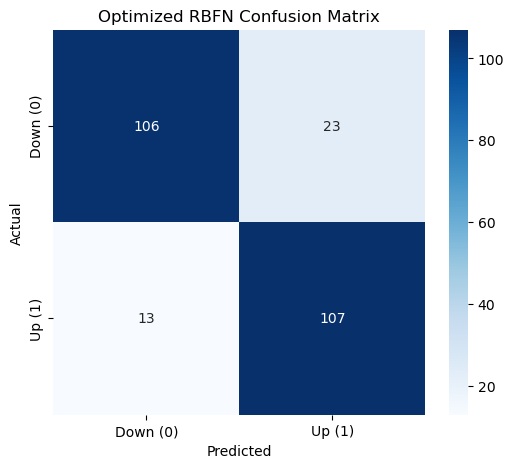

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- RBFN Class with gamma ---
class RBFN:
    def __init__(self, num_neurons, gamma=1.0, reg_param=0.0):
        self.num_neurons = num_neurons
        self.gamma = gamma
        self.reg_param = reg_param

    def _basis(self, r):
        return np.exp(-self.gamma * r**2)

    def _calculate_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X):
        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_pred = G @ self.weights
        return (y_pred > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    gamma = trial.suggest_float("gamma", 0.001, 10.0, log=True)
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = RBFN(num_neurons=num_neurons, gamma=gamma, reg_param=reg_param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Params and Final Model ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = RBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized RBFN Confusion Matrix")
plt.show()


## Fractalized Gaussian RBF

In [4]:
# !pip install optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function
def classical_gaussian_rbf(r, center=0.0, gamma=1.0):
    return np.exp(-gamma * (r - center)**2)

def base_function(r, center=0.0, gamma=1.0):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_gaussian_rbf(r0, center=center, gamma=gamma)
    phi1 = classical_gaussian_rbf(r1, center=center, gamma=gamma)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals, center=0.0, gamma=1.0):
    phi_val = classical_gaussian_rbf(u_i(i, r, intervals), center=center, gamma=gamma)
    base_val = base_function(r, center=center, gamma=gamma)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration with recursive point generation
def iterate_fractal_operator(alpha, intervals, center=0.0, gamma=1.0, max_iter=4):
    r_list = [np.array([0.0,np.sqrt(6)])]
    phi_dict = {}

    # Base evaluation
    r0 = r_list[0]
    phi0 = base_function(r0 , center=center, gamma=gamma)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):

            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]

            # Map inverse from u_i
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals, center=center, gamma=gamma)

            r_new.extend(r_i)
            phi_new.extend(v_vals)

        # Sort and deduplicate
        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

        # print(f"Iteration {d}: {len(r_new)} points")

    return r_list[-1], phi_dict[max_iter]  # Rescale back to r domain

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_Gaussian:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, gamma=1.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.gamma = gamma
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter


    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            center=center, gamma=self.gamma,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0  # no regularization on bias

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return y_score  # raw scores
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    max_iter = trial.suggest_int("max_iter", 3,10)


    model = FractalizedRBFN_Gaussian(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        gamma=gamma,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
best_model = FractalizedRBFN_Gaussian(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    gamma=best_params['gamma'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

# Evaluation Metrics
print("Best Params:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



[I 2025-05-19 13:12:31,999] A new study created in memory with name: no-name-12a8b700-a26b-4246-bb88-7ba75554346a
[I 2025-05-19 13:12:32,146] Trial 0 finished with value: 0.7251908396946565 and parameters: {'num_neurons': 123, 'alpha1': -0.2564533306120529, 'alpha2': 0.013897779081329609, 'reg_param': 0.0012642776093433556, 'gamma': 2.2196891628990385, 'max_iter': 7}. Best is trial 0 with value: 0.7251908396946565.
[I 2025-05-19 13:12:32,255] Trial 1 finished with value: 0.6274509803921569 and parameters: {'num_neurons': 46, 'alpha1': -0.34565975006707284, 'alpha2': -0.23165753914252873, 'reg_param': 0.002831097109603283, 'gamma': 1.5266007992516943, 'max_iter': 9}. Best is trial 0 with value: 0.7251908396946565.
[I 2025-05-19 13:12:32,719] Trial 2 finished with value: 0.7859922178988327 and parameters: {'num_neurons': 146, 'alpha1': 0.3243577543593874, 'alpha2': -0.026349604648450042, 'reg_param': 0.001694770560082262, 'gamma': 0.14359954009578763, 'max_iter': 10}. Best is trial 2 wit

Best Params: {'num_neurons': 142, 'alpha1': 0.3547036632046753, 'alpha2': 0.3671407389791663, 'reg_param': 0.0025846097881739405, 'gamma': 4.1988261034544205, 'max_iter': 8}
Accuracy: 0.8594377510040161
F1 Score: 0.8594377510040161
Confusion Matrix:
 [[107  22]
 [ 13 107]]


## multi-quadratic 

[I 2025-05-19 15:44:18,268] A new study created in memory with name: no-name-4e417153-57ce-43e4-99b5-42537ac7a835
[I 2025-05-19 15:44:18,378] Trial 0 finished with value: 0.8273092369477911 and parameters: {'num_neurons': 76, 'c': 2.383292429082338, 'gamma': 5.923798500063171, 'reg_param': 0.0017339522706034732}. Best is trial 0 with value: 0.8273092369477911.
[I 2025-05-19 15:44:18,451] Trial 1 finished with value: 0.8267716535433071 and parameters: {'num_neurons': 84, 'c': 0.36516937488085666, 'gamma': 0.8439315907789102, 'reg_param': 0.35098569519260514}. Best is trial 0 with value: 0.8273092369477911.
[I 2025-05-19 15:44:18,521] Trial 2 finished with value: 0.671280276816609 and parameters: {'num_neurons': 98, 'c': 0.16601997482721625, 'gamma': 0.00187356268042884, 'reg_param': 6.307366428571458e-05}. Best is trial 0 with value: 0.8273092369477911.
[I 2025-05-19 15:44:18,601] Trial 3 finished with value: 0.8379446640316206 and parameters: {'num_neurons': 140, 'c': 3.508771467411348

Best Hyperparameters: {'num_neurons': 135, 'c': 0.7607932171542781, 'gamma': 2.622117253628519, 'reg_param': 0.0008137161279939436}

Final Accuracy: 0.8635
Final F1 Score: 0.8618
Confusion Matrix:
[[109  20]
 [ 14 106]]


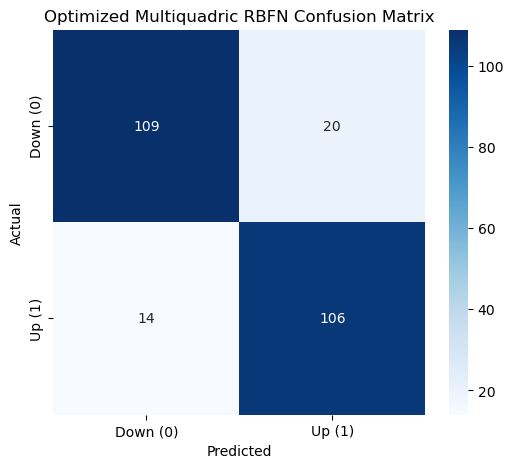

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)
# Load dataset
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Multiquadric RBFN Class ---
class RBFN:
    def __init__(self, num_neurons, c=1.0, gamma=1.0, reg_param=0.0):
        self.num_neurons = num_neurons
        self.c = c  # Shape parameter for multiquadric
        self.gamma = gamma  # Scale parameter
        self.reg_param = reg_param

    def _basis(self, r):
        return np.sqrt(1 + (self.gamma * r / self.c)**2)

    def _calculate_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))  # Add bias term

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X):
        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_pred = G @ self.weights
        return (y_pred > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    c = trial.suggest_float("c", 0.1, 10.0, log=True)  # Shape parameter
    gamma = trial.suggest_float("gamma", 0.001, 10.0, log=True)  # Scale parameter
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = RBFN(num_neurons=num_neurons, c=c, gamma=gamma, reg_param=reg_param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Params and Final Model ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = RBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Multiquadric RBFN Confusion Matrix")
plt.show()

## Fractalized multi-quadratic

In [6]:
# !pip install optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function - Modified for Multiquadric
def classical_multiquadric_rbf(r, center=0.0, c=1.0, gamma=1.0):
    return np.sqrt(1 + gamma * (r - center)**2 / c**2)

def base_function(r, center=0.0, c=1.0, gamma=1.0):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_multiquadric_rbf(r0, center=center, c=c, gamma=gamma)
    phi1 = classical_multiquadric_rbf(r1, center=center, c=c, gamma=gamma)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions (unchanged)
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals, center=0.0, c=1.0, gamma=1.0):
    phi_val = classical_multiquadric_rbf(u_i(i, r, intervals), center=center, c=c, gamma=gamma)
    base_val = base_function(r, center=center, c=c, gamma=gamma)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration with recursive point generation - Modified for Multiquadric
def iterate_fractal_operator(alpha, intervals, center=0.0, c=1.0, gamma=1.0, max_iter=4):
    r_list = [np.array([0.0,np.sqrt(6)])]
    phi_dict = {}

    # Base evaluation
    r0 = r_list[0]
    phi0 = base_function(r0, center=center, c=c, gamma=gamma)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):
            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]

            # Map inverse from u_i
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals, center=center, c=c, gamma=gamma)

            r_new.extend(r_i)
            phi_new.extend(v_vals)

        # Sort and deduplicate
        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

    return r_list[-1], phi_dict[max_iter]

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_Multiquadric:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, c=1.0, gamma=1.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.c = c  # New shape parameter for multiquadric
        self.gamma = gamma
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter

    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            center=center, c=self.c, gamma=self.gamma,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0  # no regularization on bias

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return y_score  # raw scores
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    c = trial.suggest_float("c", 0.1, 2.0)  # New parameter for multiquadric
    max_iter = trial.suggest_int("max_iter", 3,5)

    model = FractalizedRBFN_Multiquadric(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        c=c,
        gamma=gamma,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
best_model = FractalizedRBFN_Multiquadric(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    c=best_params['c'],
    gamma=best_params['gamma'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

# Evaluation Metrics
print("Best Params:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[I 2025-05-19 15:48:39,459] A new study created in memory with name: no-name-fe00502f-5e87-4c51-aa3d-d9b25d3579e9
[I 2025-05-19 15:48:39,627] Trial 0 finished with value: 0.7649402390438247 and parameters: {'num_neurons': 50, 'alpha1': 0.0029795534136268786, 'alpha2': -0.4445854796963651, 'reg_param': 0.028391907780443176, 'gamma': 0.2959879208429746, 'c': 0.614078521715425, 'max_iter': 5}. Best is trial 0 with value: 0.7649402390438247.
[I 2025-05-19 15:48:40,017] Trial 1 finished with value: 0.7 and parameters: {'num_neurons': 135, 'alpha1': -0.34925704814971437, 'alpha2': -0.20676385996184043, 'reg_param': 0.01097551589449014, 'gamma': 0.7270928338007752, 'c': 0.31977993416988304, 'max_iter': 5}. Best is trial 0 with value: 0.7649402390438247.
[I 2025-05-19 15:48:40,269] Trial 2 finished with value: 0.7389558232931727 and parameters: {'num_neurons': 178, 'alpha1': 0.07813232041000406, 'alpha2': 0.2469156906658967, 'reg_param': 0.007049175986007221, 'gamma': 0.8977458196443125, 'c': 

Best Params: {'num_neurons': 160, 'alpha1': 0.48353602760496267, 'alpha2': 0.4307524277607887, 'reg_param': 0.08640979410795756, 'gamma': 0.8467978254197102, 'c': 1.8953489414715459, 'max_iter': 5}
Accuracy: 0.8594377510040161
F1 Score: 0.8616600790513834
Confusion Matrix:
 [[105  24]
 [ 11 109]]


## Thin plate spline

[I 2025-05-19 16:00:35,367] A new study created in memory with name: no-name-d0dfd74a-3b91-405e-b1c5-cb175a68a6a8
[I 2025-05-19 16:00:35,541] Trial 0 finished with value: 0.84 and parameters: {'num_neurons': 110, 'reg_param': 0.007200651879486867}. Best is trial 0 with value: 0.84.
[I 2025-05-19 16:00:35,815] Trial 1 finished with value: 0.7722007722007722 and parameters: {'num_neurons': 36, 'reg_param': 0.034578917079857725}. Best is trial 0 with value: 0.84.
[I 2025-05-19 16:00:35,858] Trial 2 finished with value: 0.7470817120622568 and parameters: {'num_neurons': 67, 'reg_param': 0.4318942609760266}. Best is trial 0 with value: 0.84.
/var/folders/3h/zdcfhckx6rv5l6jqcnn6184r0000gn/T/ipykernel_30617/2728982604.py:28: RuntimeWarning: divide by zero encountered in log
  return np.where(r == 0, 0, r**2 * np.log(r))
/var/folders/3h/zdcfhckx6rv5l6jqcnn6184r0000gn/T/ipykernel_30617/2728982604.py:28: RuntimeWarning: invalid value encountered in multiply
  return np.where(r == 0, 0, r**2 * np

Best Hyperparameters: {'num_neurons': 122, 'reg_param': 0.0009657038663628487}

Final Accuracy: 0.8635
Final F1 Score: 0.8618
Confusion Matrix:
[[109  20]
 [ 14 106]]


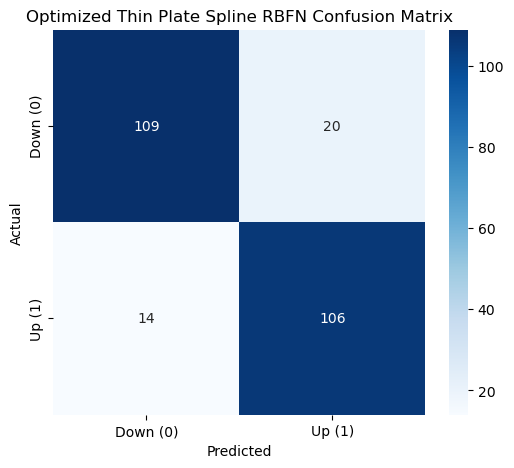

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Thin Plate Spline RBFN Class ---
class TPS_RBFN:
    def __init__(self, num_neurons, reg_param=0.0):
        self.num_neurons = num_neurons
        self.reg_param = reg_param

    def _basis(self, r):
        """Thin Plate Spline basis function: r^2 * log(r)"""
        return np.where(r == 0, 0, r**2 * np.log(r))

    def _calculate_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))  # Add bias term

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X):
        G = self._calculate_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_pred = G @ self.weights
        return (y_pred > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = TPS_RBFN(num_neurons=num_neurons, reg_param=reg_param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Params and Final Model ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = TPS_RBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Thin Plate Spline RBFN Confusion Matrix")
plt.show()


## fractalized thin plate spline

In [8]:
# !pip install optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function - Thin Plate Spline
def classical_tps_rbf(r):
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(r == 0, 1e-10, r)
        return r**2 * np.log(r)
    
def base_function(r):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_tps_rbf(r0)
    phi1 = classical_tps_rbf(r1)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals):
    phi_val = classical_tps_rbf(u_i(i, r, intervals))
    base_val = base_function(r)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration for TPS
def iterate_fractal_operator(alpha, intervals, max_iter=4):
    r_list = [np.array([0.0, np.sqrt(6)])]
    phi_dict = {}
    r0 = r_list[0]
    phi0 = base_function(r0)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):
            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals)
            r_new.extend(r_i)
            phi_new.extend(v_vals)

        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

    return r_list[-1], phi_dict[max_iter]

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_TPS:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter

    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return y_score
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    max_iter = trial.suggest_int("max_iter", 3, 5)

    model = FractalizedRBFN_TPS(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
best_model = FractalizedRBFN_TPS(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

# Evaluation Metrics
print("Best Params:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[I 2025-05-19 16:05:10,246] A new study created in memory with name: no-name-ae65c8af-152c-412b-8d4e-eccf232c1a61
[I 2025-05-19 16:05:10,336] Trial 0 finished with value: 0.7396226415094339 and parameters: {'num_neurons': 51, 'alpha1': 0.1939864754001197, 'alpha2': -0.06790475222768044, 'reg_param': 0.004657838040524651, 'max_iter': 3}. Best is trial 0 with value: 0.7396226415094339.
[I 2025-05-19 16:05:10,567] Trial 1 finished with value: 0.669260700389105 and parameters: {'num_neurons': 77, 'alpha1': -0.10962034892980388, 'alpha2': 0.172101541468077, 'reg_param': 0.0010981972593843631, 'max_iter': 5}. Best is trial 0 with value: 0.7396226415094339.
[I 2025-05-19 16:05:10,748] Trial 2 finished with value: 0.7109375 and parameters: {'num_neurons': 143, 'alpha1': 0.4506401097651971, 'alpha2': -0.13078735765992378, 'reg_param': 0.0041240836944310705, 'max_iter': 3}. Best is trial 0 with value: 0.7396226415094339.
[I 2025-05-19 16:05:10,849] Trial 3 finished with value: 0.704 and paramete

Best Params: {'num_neurons': 94, 'alpha1': -0.005550209595197384, 'alpha2': -0.3476915364792638, 'reg_param': 0.0010238020090809407, 'max_iter': 3}
Accuracy: 0.8554216867469879
F1 Score: 0.856
Confusion Matrix:
 [[106  23]
 [ 13 107]]


## inverse multiquadric RBF

[I 2025-05-19 16:12:24,628] A new study created in memory with name: no-name-5c37a7bd-5c8c-47ad-9d8c-d2e2efc8c376
[I 2025-05-19 16:12:24,688] Trial 0 finished with value: 0.8387096774193549 and parameters: {'num_neurons': 53, 'c': 0.3821485950146045, 'gamma': 0.21279855643811713, 'reg_param': 5.829817684111677e-06}. Best is trial 0 with value: 0.8387096774193549.
[I 2025-05-19 16:12:24,789] Trial 1 finished with value: 0.6666666666666666 and parameters: {'num_neurons': 123, 'c': 1.173301787574942, 'gamma': 0.0011224846834755574, 'reg_param': 0.0001742276145442615}. Best is trial 0 with value: 0.8387096774193549.
[I 2025-05-19 16:12:24,875] Trial 2 finished with value: 0.7481481481481481 and parameters: {'num_neurons': 182, 'c': 0.6317106950453092, 'gamma': 0.029759259731660343, 'reg_param': 0.25232804392602737}. Best is trial 0 with value: 0.8387096774193549.
[I 2025-05-19 16:12:24,909] Trial 3 finished with value: 0.6842105263157895 and parameters: {'num_neurons': 38, 'c': 0.824729959

Best Hyperparameters: {'num_neurons': 170, 'c': 0.12940751436985531, 'gamma': 0.0602320208422778, 'reg_param': 1.7337694443401478e-06}

Final Accuracy: 0.8675
Final F1 Score: 0.8631
Confusion Matrix:
[[112  17]
 [ 16 104]]


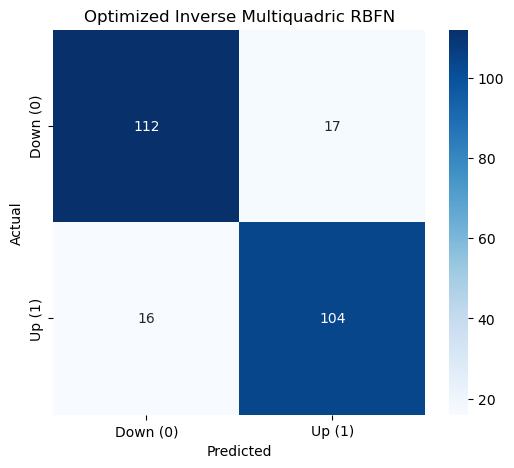

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import optuna

# Set seed
np.random.seed(42)

# Load dataset
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Inverse Multiquadric RBFN Class ---
class InverseMultiquadricRBFN:
    def __init__(self, num_neurons, c=1.0, gamma=1.0, reg_param=0.0):
        self.num_neurons = num_neurons
        self.c = c  # Shape parameter for inverse multiquadric
        self.gamma = gamma  # Scale parameter
        self.reg_param = reg_param

    def _basis(self, r, center=0.0):
        return 1.0 / np.sqrt(1 + self.gamma * (r - center)**2 / self.c**2)

    def _calculate_interpolation_matrix(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            r = np.linalg.norm(X - center, axis=1)
            G[:, i] = self._basis(r)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        G = self._calculate_interpolation_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))  # Add bias term

        I = np.identity(G.shape[1])
        I[0, 0] = 0  # No regularization for bias
        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = self._calculate_interpolation_matrix(X.values, self.centers)
        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return 1 / (1 + np.exp(-y_score))  # Sigmoid for probabilities
        return (y_score > 0.5).astype(int)

# --- Optuna Objective ---
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    c = trial.suggest_float("c", 0.1, 10.0, log=True)  # Shape parameter
    gamma = trial.suggest_float("gamma", 0.001, 10.0, log=True)  # Scale parameter
    reg_param = trial.suggest_float("reg_param", 1e-6, 1.0, log=True)

    model = InverseMultiquadricRBFN(
        num_neurons=num_neurons,
        c=c,
        gamma=gamma,
        reg_param=reg_param
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# --- Run Optuna ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# --- Best Model Evaluation ---
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = InverseMultiquadricRBFN(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_proba = final_model.predict(X_test, return_proba=True)

# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"],
            yticklabels=["Down (0)", "Up (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Inverse Multiquadric RBFN")
plt.show()


## Fractalized inverse multi-quadric

In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import optuna

# Base RBF and base function - Modified for Inverse Multiquadric
def classical_inverse_multiquadric_rbf(r, center=0.0, c=1.0, gamma=1.0):
    return 1.0 / np.sqrt(1 + gamma * (r - center)**2 / c**2)

def base_function(r, center=0.0, c=1.0, gamma=1.0):
    r0, r1 = 0, np.sqrt(6)
    phi0 = classical_inverse_multiquadric_rbf(r0, center=center, c=c, gamma=gamma)
    phi1 = classical_inverse_multiquadric_rbf(r1, center=center, c=c, gamma=gamma)
    return (phi1 - phi0) / (r1 - r0) * r + phi0

# Affine mapping functions
def u_i(i, r, intervals):
    a = (intervals[i] - intervals[i-1]) / (intervals[-1] - intervals[0])
    b = intervals[i-1] - a * intervals[0]
    return a * r + b

def v_i(i, r, t, alpha, intervals, center=0.0, c=1.0, gamma=1.0):
    phi_val = classical_inverse_multiquadric_rbf(u_i(i, r, intervals), center=center, c=c, gamma=gamma)
    base_val = base_function(r, center=center, c=c, gamma=gamma)
    return phi_val + alpha[i-1] * (t - base_val)

# Fractal iteration with recursive point generation
def iterate_fractal_operator(alpha, intervals, center=0.0, c=1.0, gamma=1.0, max_iter=4):
    r_list = [np.array([0.0, np.sqrt(6)])]
    phi_dict = {}

    # Base evaluation
    r0 = r_list[0]
    phi0 = base_function(r0, center=center, c=c, gamma=gamma)
    phi_dict[0] = phi0

    for d in range(1, max_iter + 1):
        r_prev = r_list[-1]
        r_new = []
        phi_new = []

        for i in range(1, len(intervals)):
            r_i = u_i(i, r_prev, intervals)
            t_i = phi_dict[d - 1]

            # Map inverse from u_i
            r_inv = (r_i - intervals[i-1]) / (intervals[i] - intervals[i-1])
            v_vals = v_i(i, r_inv, t_i, alpha, intervals, center=center, c=c, gamma=gamma)

            r_new.extend(r_i)
            phi_new.extend(v_vals)

        # Sort and deduplicate
        r_new = np.array(r_new)
        phi_new = np.array(phi_new)
        sort_idx = np.argsort(r_new)
        r_new = r_new[sort_idx]
        phi_new = phi_new[sort_idx]

        r_list.append(r_new)
        phi_dict[d] = phi_new

    return r_list[-1], phi_dict[max_iter]

# ----------------- RBF Model Class ------------------
class FractalizedRBFN_InverseMultiquadric:
    def __init__(self, num_neurons, alpha_list, reg_param=0.0, c=1.0, gamma=1.0, max_iter=4):
        self.num_neurons = num_neurons
        self.alpha_list = alpha_list
        self.reg_param = reg_param
        self.c = c  # Shape parameter for inverse multiquadric
        self.gamma = gamma
        self.intervals = [0, np.sqrt(6)/2, np.sqrt(6)]
        self.max_iter = max_iter

    def _fractalized_basis(self, r, center):
        r_vals, phi_vals = iterate_fractal_operator(
            self.alpha_list, self.intervals,
            center=center, c=self.c, gamma=self.gamma,
            max_iter=self.max_iter
        )
        return np.interp(r, r_vals, phi_vals)

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_neurons, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))  # bias
        I = np.identity(G.shape[1])
        I[0, 0] = 0  # no regularization on bias

        self.weights = np.linalg.inv(G.T @ G + self.reg_param * I) @ G.T @ y.values

    def predict(self, X, return_proba=False):
        G = np.zeros((X.shape[0], self.num_neurons))
        for i, center in enumerate(self.centers):
            r = np.linalg.norm(X.values - center, axis=1)
            G[:, i] = self._fractalized_basis(r, center=0.0)

        G = np.hstack((np.ones((G.shape[0], 1)), G))
        y_score = G @ self.weights

        if return_proba:
            return 1 / (1 + np.exp(-y_score))  # sigmoid transformation
        else:
            return (y_score > 0.5).astype(int)

# ----------------- Optuna Hyperparameter Tuning ------------------
def objective(trial):
    num_neurons = trial.suggest_int("num_neurons", 10, 200)
    alpha1 = trial.suggest_float("alpha1", -0.5, 0.5)
    alpha2 = trial.suggest_float("alpha2", -0.5, 0.5)
    reg_param = trial.suggest_float("reg_param", 0.001, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)
    c = trial.suggest_float("c", 0.1, 2.0)  # Shape parameter for inverse multiquadric
    max_iter = trial.suggest_int("max_iter", 2, 5)

    model = FractalizedRBFN_InverseMultiquadric(
        num_neurons=num_neurons,
        alpha_list=[alpha1, alpha2],
        reg_param=reg_param,
        c=c,
        gamma=gamma,
        max_iter=max_iter
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# ----------------- Load Data ------------------
df = pd.read_csv("SP500_normalized.csv")
technical_indicators = ["SMA", "MACD", "%K", "%D", "RSI", "Williams %R"]
X = df[technical_indicators]
y = df["Direction"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Run Optuna ------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

# ----------------- Best Model Evaluation ------------------
best_params = study.best_params
print("Best Parameters:", best_params)

best_model = FractalizedRBFN_InverseMultiquadric(
    num_neurons=best_params['num_neurons'],
    alpha_list=[best_params['alpha1'], best_params['alpha2']],
    reg_param=best_params['reg_param'],
    c=best_params['c'],
    gamma=best_params['gamma'],
    max_iter=best_params['max_iter']
)
best_model.fit(X_train, y_train)

# Evaluation metrics and plots
y_pred = best_model.predict(X_test)
y_score = best_model.predict(X_test, return_proba=True)

print("\nPerformance Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[I 2025-05-19 16:16:26,293] A new study created in memory with name: no-name-a6c910fd-13d2-4410-94d2-ba3483a232f2
[I 2025-05-19 16:16:26,377] Trial 0 finished with value: 0.8 and parameters: {'num_neurons': 79, 'alpha1': 0.02061473914511125, 'alpha2': -0.26034436871784017, 'reg_param': 0.019078477080827296, 'gamma': 3.1203622558865436, 'c': 1.741926635560839, 'max_iter': 4}. Best is trial 0 with value: 0.8.
[I 2025-05-19 16:16:26,606] Trial 1 finished with value: 0.7142857142857143 and parameters: {'num_neurons': 126, 'alpha1': -0.4033736366917282, 'alpha2': -0.34668345719788896, 'reg_param': 0.006765071188656368, 'gamma': 0.9682023059316441, 'c': 1.2215894728275989, 'max_iter': 5}. Best is trial 0 with value: 0.8.
[I 2025-05-19 16:16:26,711] Trial 2 finished with value: 0.8145161290322581 and parameters: {'num_neurons': 114, 'alpha1': 0.3152620374396695, 'alpha2': 0.41202313216415976, 'reg_param': 0.0019356780844706966, 'gamma': 4.760543929014586, 'c': 0.24743313388978555, 'max_iter':

Best Parameters: {'num_neurons': 119, 'alpha1': 0.4246001623660366, 'alpha2': 0.03260957546758439, 'reg_param': 0.087815318664407, 'gamma': 3.396406776892101, 'c': 0.3478081387963853, 'max_iter': 2}

Performance Metrics:
Accuracy: 0.8634538152610441
F1 Score: 0.864
Confusion Matrix:
 [[107  22]
 [ 12 108]]
